<a href="https://colab.research.google.com/github/bcreagh96/Assignment2_classification/blob/main/Assignment2_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Deep Convolutional Neural Network on CIFAR-10 Dataset

In this assignment, we will gain some practical experience of coding a deep convolutional neural network in Tensorflow. The simplest way to code a network is to use the High level Keras API within Tensorflow.  

## (a) Introduction

 In this assignment to reduce training time and computation, we will train our network using the simple [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
![link text](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

The goal of this Etivity is to build and train your own Deep Convolutional Neural Network. This notebook contains standard keras/Tensorflow code to perform data processing, training set up and testing metrics, as outlined in the steps below. This will allow you to focus on developing the architecture & code for your network.

1. Load Dataset - We will import the CIFAR-10 Dataset using the Tensorflow Data Set API.
2. Prepare Data - We will slightly modify the dataset before it is sent to the model for training.
3. Model Coding - We will write code to build the model using the Tensorflow keras API.
  * **You will code your neural network model in this section**
4. Compile Model - We will complile the model and verify that it has been correctly constructed.
5. Train Model - We will train the model using the imported dataset.
6. Test Model - We test the model on the training data and obtain a classification report and confusion matrix.

The principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials. Tutorials on [image classification](https://www.tensorflow.org/tutorials/images/classification) and [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) are useful for this Etivity.  

Please see the rubric on the module Brightspace site to understand how the assignment will be scored.

#House Keeping

Import Packages

In [1]:
!git clone https://github.com/ckyrkou/Keras_FLOP_Estimator

Cloning into 'Keras_FLOP_Estimator'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 176 (delta 3), reused 0 (delta 0), pack-reused 165
Receiving objects: 100% (176/176), 140.48 KiB | 2.23 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
import sys
sys.path.insert(0, 'Keras_FLOP_Estimator/python_code')

In [3]:
from __future__ import print_function


import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from net_flops import net_flops

import numpy as np

To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU.

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

#1. Load Dataset

In this assignment, we will be using the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.htmlhttps://). CIFAR-10 is often used as a "Hello World" dataset that is often used to ensure a network architecture is working before moving on to training with more complex datasets.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (airplane, automobile, **bird**, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. There are 50,000 training images and 10,000 test images.

We will use the [Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) API to download the CIFAR10 dataset.

In [5]:
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =32       # Image Height (fixed)
W_trg =32       # image Width (fixed)

# Labels corresponding to categories
label_str = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# We initally load the raw training/validation/test dataset
import tensorflow_datasets as tfds
ds,info= tfds.load("cifar10",with_info=True)

raw_train = tfds.load('cifar10', split='train[0%:90%]')
raw_val = tfds.load('cifar10', split='train[91%:100%]')
raw_test = tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteSOVVSD/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteSOVVSD/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# 2. Prepare Data

After importing raw datasets using tfds load, we create an input pipeline that processes & batches this data before it is supplied to the model for training using the virtual machine GPU.

In [7]:

def data_pipe(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image-0.5
  label = tf.cast(label, tf.float32)
  return image,label


In [8]:
def gen_tr_datasets(src_dataset):
    # Define Datasets
    #src_dataset = src_dataset.shuffle(num_train_examples)
    tr_dataset = src_dataset.map(lambda x: (x['image'],x['label']))
    tr_dataset = tr_dataset.map(data_pipe)
    tr_dataset = tr_dataset.batch(batch_size)
    return tr_dataset

def gen_val_datasets(src_dataset):
    # Define Datasets
    test_dataset = src_dataset.map(lambda x: (x['image'],x['label']))
    test_dataset = test_dataset.map(data_pipe)
    test_dataset = test_dataset.batch(batch_size)
    return test_dataset
# Generate the datasets
train_dataset = gen_tr_datasets(raw_train)
val_dataset = gen_val_datasets(raw_val)
test_dataset = gen_val_datasets(raw_test)

Plot some examples of the training dataset.

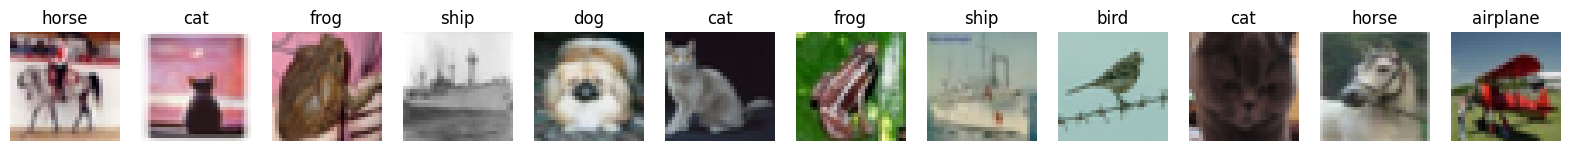

In [9]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image, label in train_dataset.take(n_plots):  # Only take a single example
  axarr[i].imshow(image[0,:,:,:]+0.5)
  axarr[i].axis('off')
  axarr[i].title.set_text(label_str[int(label[0])])
  i = i+1



# 3. Model Coding

In this section You may develop your own model architecture to perform image recognition with the CIFAR-10 Dataset.

In the code cell below, an incomplete skeleton function is provided for your top level.  
* This uses the Keras functional API
* You can add your own layers/repeating units etc to build your own architecture within the function.
* Common Keras Layers:
 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
 * [Average Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) & [Max Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D)
 * [Global Average Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation)

* You may also improve the performance of your architecture during training using any of the various regularisation methods available in Keras:
 * [L1 & L2 Regularisation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)
 * [Dropout Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
 * [Spatial Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout2D)
 * Data Augmentation Layers, E.g. [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomCrop). See [Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) tutorial for usage example.
 * [Batch Normalisation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Please Leave a note at the end of the notebook explaining your approach/results for the e-moderator.

In [20]:
from tensorflow.keras import datasets, layers, models
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    # Define input of model
    inputs = Input(shape=input_shape)


   ######## Add more layers to build your Architecture here ##################
    #data augmentation
    flip1 = layers.RandomFlip(mode="horizontal", seed=None)

    #conv layers
    conv1_1 = layers.Conv2D(32, (3, 3), activation='relu')
    conv1_2 = layers.Conv2D(32, (3, 3), activation='relu')
    conv2_1 = layers.Conv2D(64, (3, 3), activation='relu')
    conv2_2 = layers.Conv2D(64, (3, 3), activation='relu')
    conv3_1 = layers.Conv2D(128, (3, 3), activation='relu')
    conv3_2 = layers.Conv2D(128, (3, 3), activation='relu')
    conv4_1 = layers.Conv2D(256, (3, 3), activation='relu')
    conv4_2 = layers.Conv2D(256, (3, 3), activation='relu')
    #pooling
    pool1 = layers.MaxPooling2D((2, 2))
    pool2 = layers.MaxPooling2D((2, 2))
    pool3 = layers.MaxPooling2D((2, 2))
    #flatten
    flatten = layers.Flatten()
    #dense layers
    dense1 = layers.Dense(128, activation='relu')
    dense2 = layers.Dense(64, activation='relu')
    #kernel_regularizer=tf.keras.regularizers.L1(0.01),
    #activity_regularizer=tf.keras.regularizers.L2(0.01), activation='relu')
    dense3 = layers.Dense(num_classes, activation='softmax')
    #Regurlarisation
    drop1 = layers.Dropout(.2, input_shape = (None, 15, 15, 32))
    drop2 = layers.Dropout(.3, input_shape = (None, 6, 6, 64))
    drop3 = layers.Dropout(.5, input_shape = (None, 64))

    # Connect Network
    x = flip1(inputs)
    x = conv1_1(x)
    x = BatchNormalization()(x)
    x = conv1_2(x)
    x = pool1(x)
    x = drop1(x)
    x = conv2_1(x)
    x = BatchNormalization()(x)
    x = conv2_2(x)
    x = pool2(x)
    x = drop2(x)
    x = conv3_1(x)
    x = BatchNormalization()(x)
    x = conv3_2(x)
    #x = conv4_1(x)
    #x = BatchNormalization(x)
    #x = conv4_2(x)
    x = flatten(x)
    x = dense1(x)
    x = dense2(x)
    x = BatchNormalization()(x)
    x = drop3(x)
    x = dense3(x)
    outputs = x
    # Add final stages. (Ensure that you call the output of the very last layer outputs)


    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We define  loss function, the optimizer and metrics.

Note the use here of [Sparse Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). This loss function allows us to input integer values for true classes. With the regular categorical cross entropy loss function the supplied labels must be frist converted to a one-hot representation,  but this special loss function allows us to avoid manually converting to the one-hot representation.

We will use the python package net_flops to estimate the computatational load of the model. Typically


In [21]:
# Compile Model
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# Obtain summary containing number of paramters
model.summary()
# Obtain summary of floating point operations in network
net_flops(model,table=True)

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                      

# 5. Model Training

We will now train the complied model on the cifar10 dataset using the tensorflow keras `model.fit` method.

Note that the number of epochs is set to a high number, you may not require this many epochs to train your network. [Early Stopping](https://keras.io/api/callbacks/early_stopping/) has been included to stop training once validation loss stops improving. You may wish to adjust the paramters (such as start_from_epoch) to suit your particular architecture.


In [12]:
# Set max training epochs
epochs = 55
# Enable callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,start_from_epoch=10)
# Train Model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,callbacks=[callback])

Epoch 1/55
1407/1407 [==============================] - 36s 16ms/step - loss: 1.7472 - accuracy: 0.3812 - val_loss: 1.3155 - val_accuracy: 0.5264
Epoch 2/55
1407/1407 [==============================] - 15s 11ms/step - loss: 1.2730 - accuracy: 0.5570 - val_loss: 1.0560 - val_accuracy: 0.6124
Epoch 3/55
1407/1407 [==============================] - 18s 13ms/step - loss: 1.0835 - accuracy: 0.6265 - val_loss: 0.8686 - val_accuracy: 0.6900
Epoch 4/55
1407/1407 [==============================] - 15s 11ms/step - loss: 0.9644 - accuracy: 0.6728 - val_loss: 0.8216 - val_accuracy: 0.7140
Epoch 5/55
1407/1407 [==============================] - 15s 11ms/step - loss: 0.8796 - accuracy: 0.7042 - val_loss: 0.7447 - val_accuracy: 0.7382
Epoch 6/55
1407/1407 [==============================] - 18s 12ms/step - loss: 0.8216 - accuracy: 0.7235 - val_loss: 0.7389 - val_accuracy: 0.7409
Epoch 7/55
1407/1407 [==============================] - 22s 16ms/step - loss: 0.7724 - accuracy: 0.7424 - val_loss: 0.6711 -

We will plot the loss and accuracy for the training and validation data sets.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


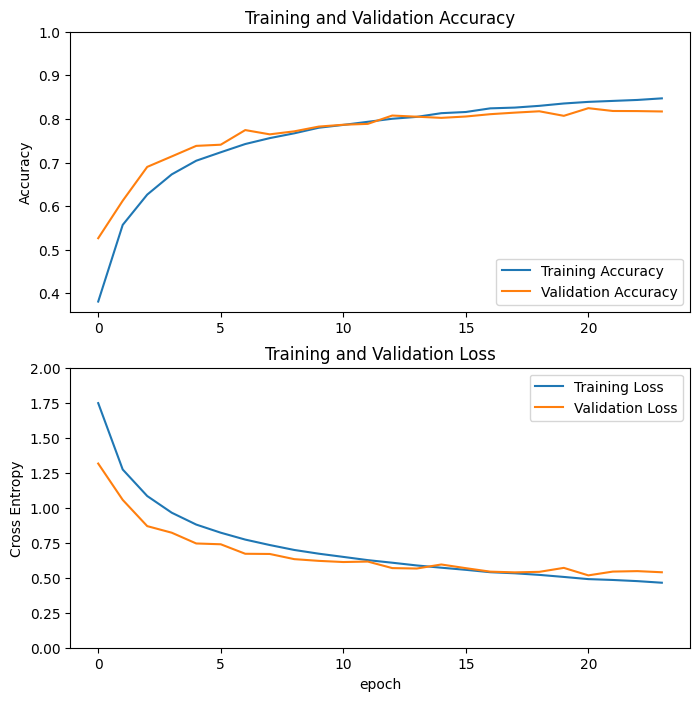

In [13]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 6. Model Testing
We will iterate through the test data and analyse the results using tools from sklearn. We create a classification report, a confusion matrix and also plot a few examples from the test set.

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

In [14]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))


Create and plot a confusion matrix.

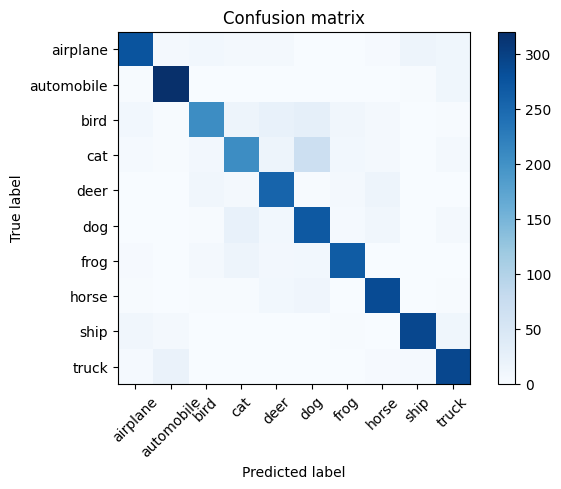

In [15]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

Generate & print the classification report

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.88      0.82      0.85       337
  automobile       0.90      0.95      0.92       338
        bird       0.84      0.67      0.75       306
         cat       0.73      0.63      0.68       323
        deer       0.78      0.86      0.82       297
         dog       0.68      0.83      0.75       325
        frog       0.89      0.86      0.88       307
       horse       0.86      0.90      0.88       317
        ship       0.92      0.89      0.91       326
       truck       0.85      0.90      0.87       324

    accuracy                           0.83      3200
   macro avg       0.83      0.83      0.83      3200
weighted avg       0.83      0.83      0.83      3200



Plot some test images and predicted labels.

(32, 10)
(32,)
Predictions:
 [7 0 6 9 7 1 7 0 5 4 7 2 7 9 2 8 8 8 7 1 4 5 3 5 0 0 2 8 1 8 2 0]


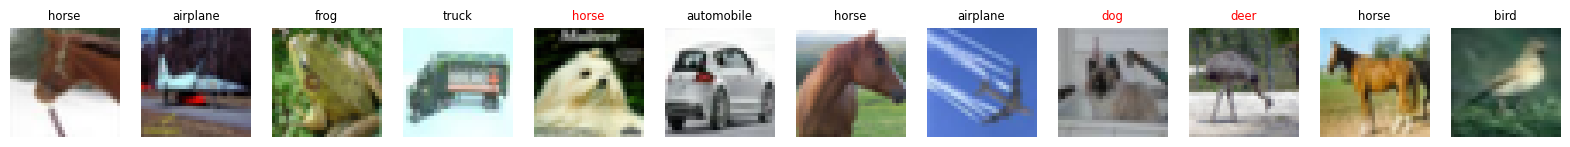

In [17]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')

  color = ('black' if predictions[i] == int(label_batch[i]) else 'red')
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1

# Please Leave a note here explaining your approach/results for the e-moderator.


Please clearly identify any code blocks you have used, suggestions your have tried or ideas obtained from other students. This information may also be posted as a final reflection post in the forum.


Data preprocessing: To add more training data, I decided to augment the data with Randomflip, with only horizontal flips activated. My reasoning being that veritcal flips of images of animals typically won't look like images of animals in most use cases, so cutting out these flips should cut down on training time. There would however be an argument for adding vertical flips to increase model robustness, as an image identifyer should reconise images regardless of their orientation.  

Network structure: I opted to add three convolutional blocks, with increasing kernal size in order for the model to learn differnt types of image features. Batch normalisation was added in order to normalise model weights and prevent issues with the gradient during back-propagation. This was pointed out to me in the forums, thanks to Paul.

Regularisation: I added dropout layers to each block in order to prevent overfitting, with increasing r values in order to prevent the model from relying on one layer over another. This technique was learned from Darrens post in the forum.

Results: This model achieves a weighted average precision, recall, and f1-score of  accuracy of 0.83.

Computation: Max pooling was added to cut down on computation.
Total params: 313578 (1.20 MB)
Trainable params: 313002 (1.19 MB)
Non-trainable params: 576 (2.25 KB)
Total FLOPS (x 10^6): 42.62297600
Total MACCs: 21295744.00000000

Improvements/Conclusion: Further improvement may be achieved with added complexity to the model and possibly by adding more data with data augmentation, due to relatively little overfitting observed yet.